In [10]:
import requests
import json
import numpy as np
import pandas as pd
from unicodedata import normalize
from sqlalchemy import create_engine
import os
import psycopg2
import io
import matplotlib.pyplot as plt
import warnings
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from datetime import date
from datetime import datetime
from matplotlib import pyplot
from IPython.display import Image
from collections import OrderedDict
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from xgboost import XGBRegressor, XGBRFRegressor, plot_importance
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score, KFold

In [11]:
## Code to read csv file into Colaboratory:
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
## Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

In [12]:
#id = '1hr1Lyzg9Vv3DWL6vvauC6_33lUX2iLlv'
#downloaded = drive.CreateFile({'id':id}) 
#downloaded.GetContentFile('vista_unica.csv')  
#df_vista_unica = pd.read_csv('vista_unica.csv')

In [13]:
#Conexión con la base de datos
host = 'team73test.c4xr0dadx0gz.us-east-2.rds.amazonaws.com'
port = 5432
user = 'postgres'
password = 'ds4a_t73'
database = 'postgres'
connDB = create_engine(f'postgresql://{user}:{password}@{host}:{port}/{database}')
conn = connDB.raw_connection()
cur = conn.cursor()
%load_ext sql
%sql postgresql://{user}:{password}@{host}/{database}

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: postgres@postgres'

In [14]:
df_vista_unica = pd.read_sql(''' SELECT * FROM carguebogota.vistaunica ''', conn)

Las variables categoricas en esta tabla son:




*   hour: Hora
*   month: Mes
*   weekday: Dia semana
*   direction: 1 sale de Bogotá y 0 significa entra a Bogotá
*   cargo_accident: 1 significa que hubo al menos un vehiculo de carga involucrado en accidente y 0 no
*   accident: 1 significa que hubo un acciden y 0 que no
*   direccion_act: 1 significa que el accidente se produjo en el sentido entrando a Bogotá y 0 saliendo de Bogotá
*   corridor: Es el nombre del corredor







Las variables numéricas son

* c2g: numero de camiones tipo c2g que transitaron en la fecha y hora
*	c2p: numero de camiones tipo c2p que transitaron en la fecha y hora
*	tractocamiones: numero de camiones tipo tractocamiones que transitaron en la fecha y hora 
* camiones_equiv: Suma ponderada de las tres variables anteriores
* average_speed_total: Velocidad promedio total de la calle y sentido	
* average_speed_tramo: Velocidad promedio total de la calle, tramo y sentido	
* precipitation: Precipitacion por hora en la estación meteorologica del aeropuerto El Dorado


# Transformaciones iniciales

In [15]:
df_vista_unica["datetime"] = pd.to_datetime(df_vista_unica["date"])
df_vista_unica["direction"] = df_vista_unica["direction"].astype(int)
df_vista_unica["total_camiones"] = df_vista_unica["c2g"] + df_vista_unica["c2p"] + df_vista_unica["tractocamiones"]
df_vista_unica["pctge_c2g"] = round(df_vista_unica["c2g"]/df_vista_unica["total_camiones"],2)*100
df_vista_unica["pctge_c2p"] = round(df_vista_unica["c2p"]/df_vista_unica["total_camiones"],2)*100
df_vista_unica["pctge_tractocamiones"] = round(df_vista_unica["tractocamiones"]/df_vista_unica["total_camiones"],2)*100
df_vista_unica

,date,hour,month,weekday,c2g,c2p,tractocamiones,camiones_equiv,direction,average_speed_total,average_speed_tramo,cargo_accident,accident,direccion_act,corridor,precipitation,datetime,total_camiones,pctge_c2g,pctge_c2p,pctge_tractocamiones
0,2019-01-01,0,1,Tuesday,0,0,1,3.0,0,48.482650,39.452538,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0
1,2019-01-01,0,1,Tuesday,0,0,1,3.0,1,47.939003,48.416683,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0
2,2019-01-01,1,1,Tuesday,0,0,1,3.0,0,48.001421,40.022312,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0
3,2019-01-01,1,1,Tuesday,0,0,1,3.0,1,41.782974,43.134039,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0
4,2019-01-01,2,1,Tuesday,0,0,1,3.0,0,44.588264,39.019569,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27658,2019-12-31,18,12,Tuesday,0,3,3,12.0,0,33.181735,37.486182,0,0,0.0,CL80,0.0,2019-12-31,6,0.0,50.0,50.0
27659,2019-12-31,19,12,Tuesday,0,3,3,12.0,0,34.528984,41.187321,0,0,0.0,CL80,0.0,2019-12-31,6,0.0,50.0,50.0
27660,2019-12-31,20,12,Tuesday,0,2,0,2.0,0,34.546533,42.067074,0,0,0.0,CL80,0.0,2019-12-31,2,0.0,100.0,0.0
27661,2019-12-31,21,12,Tuesday,1,2,1,7.0,0,37.451145,43.793395,0,0,0.0,CL80,0.0,2019-12-31,4,25.0,50.0,25.0


In [16]:
df_pctge_promedio_camiones_hora_dia_calle_tramo = df_vista_unica.groupby(["corridor", "direction", "month", "weekday", "hour"]).agg({"pctge_c2g": ["mean"], "pctge_c2p": ["mean"], "pctge_tractocamiones": ["mean"]})
df_pctge_promedio_camiones_hora_dia_calle_tramo.columns =  ["_".join(x) for x in df_pctge_promedio_camiones_hora_dia_calle_tramo.columns.ravel()]
df_pctge_promedio_camiones_hora_dia_calle_tramo = df_pctge_promedio_camiones_hora_dia_calle_tramo.reset_index()
df_pctge_promedio_camiones_hora_dia_calle_tramo

,corridor,direction,month,weekday,hour,pctge_c2g_mean,pctge_c2p_mean,pctge_tractocamiones_mean
0,CL13,0,1,Friday,0,0.000000,70.750000,29.250000
1,CL13,0,1,Friday,1,6.000000,59.000000,35.000000
2,CL13,0,1,Friday,2,0.000000,61.250000,38.750000
3,CL13,0,1,Friday,3,0.000000,74.000000,26.000000
4,CL13,0,1,Friday,4,1.750000,63.250000,35.000000
...,...,...,...,...,...,...,...,...
8004,CL80,1,12,Wednesday,19,1.333333,66.000000,33.000000
8005,CL80,1,12,Wednesday,20,0.000000,86.000000,14.000000
8006,CL80,1,12,Wednesday,21,4.333333,31.666667,64.000000
8007,CL80,1,12,Wednesday,22,0.000000,44.333333,55.666667


In [17]:
#Export df to csv
#from google.colab import drive
#drive.mount('drive',force_remount=True)
#df_pctge_promedio_camiones_hora_dia_calle_tramo.to_csv('df_pctge_promedio_camiones_hora_dia_calle_tramo.csv')
#!cp df_pctge_promedio_camiones_hora_dia_calle_tramo.csv "drive/My Drive/DS4A - TEAM73/DATA/Modelos"

In [18]:
df_vista_unica['corridor_label'] = df_vista_unica['corridor'].astype("category").cat.codes
df_vista_unica

,date,hour,month,weekday,c2g,c2p,tractocamiones,camiones_equiv,direction,average_speed_total,average_speed_tramo,cargo_accident,accident,direccion_act,corridor,precipitation,datetime,total_camiones,pctge_c2g,pctge_c2p,pctge_tractocamiones,corridor_label
0,2019-01-01,0,1,Tuesday,0,0,1,3.0,0,48.482650,39.452538,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0,0
1,2019-01-01,0,1,Tuesday,0,0,1,3.0,1,47.939003,48.416683,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0,0
2,2019-01-01,1,1,Tuesday,0,0,1,3.0,0,48.001421,40.022312,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0,0
3,2019-01-01,1,1,Tuesday,0,0,1,3.0,1,41.782974,43.134039,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0,0
4,2019-01-01,2,1,Tuesday,0,0,1,3.0,0,44.588264,39.019569,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27658,2019-12-31,18,12,Tuesday,0,3,3,12.0,0,33.181735,37.486182,0,0,0.0,CL80,0.0,2019-12-31,6,0.0,50.0,50.0,1
27659,2019-12-31,19,12,Tuesday,0,3,3,12.0,0,34.528984,41.187321,0,0,0.0,CL80,0.0,2019-12-31,6,0.0,50.0,50.0,1
27660,2019-12-31,20,12,Tuesday,0,2,0,2.0,0,34.546533,42.067074,0,0,0.0,CL80,0.0,2019-12-31,2,0.0,100.0,0.0,1
27661,2019-12-31,21,12,Tuesday,1,2,1,7.0,0,37.451145,43.793395,0,0,0.0,CL80,0.0,2019-12-31,4,25.0,50.0,25.0,1


In [19]:
df_vista_unica_dummies = pd.get_dummies(df_vista_unica, columns=["hour",	"month",	"weekday"], drop_first=False)

In [20]:
df_vista_unica_dummies

,date,c2g,c2p,tractocamiones,camiones_equiv,direction,average_speed_total,average_speed_tramo,cargo_accident,accident,direccion_act,corridor,precipitation,datetime,total_camiones,pctge_c2g,pctge_c2p,pctge_tractocamiones,corridor_label,hour_0,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,2019-01-01,0,0,1,3.0,0,48.482650,39.452538,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,2019-01-01,0,0,1,3.0,1,47.939003,48.416683,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2019-01-01,0,0,1,3.0,0,48.001421,40.022312,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,2019-01-01,0,0,1,3.0,1,41.782974,43.134039,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,2019-01-01,0,0,1,3.0,0,44.588264,39.019569,0,0,0.0,CL13,0.0,2019-01-01,1,0.0,0.0,100.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27658,2019-12-31,0,3,3,12.0,0,33.181735,37.486182,0,0,0.0,CL80,0.0,2019-12-31,6,0.0,50.0,50.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
27659,2019-12-31,0,3,3,12.0,0,34.528984,41.187321,0,0,0.0,CL80,0.0,2019-12-31,6,0.0,50.0,50.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
27660,2019-12-31,0,2,0,2.0,0,34.546533,42.067074,0,0,0.0,CL80,0.0,2019-12-31,2,0.0,100.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
27661,2019-12-31,1,2,1,7.0,0,37.451145,43.793395,0,0,0.0,CL80,0.0,2019-12-31,4,25.0,50.0,25.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


# Estimación del número de vehículos de carga Calle 80 Saliendo de Bogotá

In [21]:
df_vista_unica_input = df_vista_unica_dummies[(df_vista_unica_dummies.corridor_label == 1) & (df_vista_unica_dummies.direction == 1)]

In [22]:
df_vista_unica_input = df_vista_unica_input.set_index("datetime") 

In [23]:
#Standarized average_speed_tramo and corridor
#df_vista_unica_input["average_speed_tramo"] = (df_vista_unica_input["average_speed_tramo"] - df_vista_unica_input["average_speed_tramo"].mean()) / df_vista_unica_input["average_speed_tramo"].std()
df_vista_unica_input["average_speed_total"] = (df_vista_unica_input["average_speed_total"] - df_vista_unica_input["average_speed_total"].mean()) / df_vista_unica_input["average_speed_total"].std()

df_vista_unica_input = df_vista_unica_input[["camiones_equiv",  "average_speed_total", "hour_0",	"hour_1",	"hour_2",	"hour_3",	"hour_4",	"hour_5",	"hour_6",	"hour_7",	"hour_8",	"hour_9",	"hour_10",	"hour_11",	"hour_12",	"hour_13",	"hour_14",	"hour_15",	"hour_16",	"hour_17",	"hour_18",	"hour_19",	"hour_20",	"hour_21",	"hour_22",	"hour_23",	"month_1",	"month_2",	"month_3",	"month_4",	"month_5",	"month_6",	"month_7",	"month_8", 	"month_9",	"month_10",	"month_11", 	"month_12",	"weekday_Friday",	"weekday_Monday",	"weekday_Saturday",	"weekday_Sunday",	"weekday_Thursday",	"weekday_Tuesday",	"weekday_Wednesday"]]
#df_vista_unica_input = df_vista_unica_input[["camiones_equiv", "average_speed_total", "average_speed_tramo", "month_sin", "month_cos", "day_sin", "day_cos", "hour_5",	"hour_6",	"hour_7",	"hour_11",	"hour_12",	"hour_21",	"weekday_Monday", "weekday_Saturday", "weekday_Sunday"]]


# We select X variables and response variable
X = df_vista_unica_input.drop(['camiones_equiv'], axis=1)
y = df_vista_unica_input[['camiones_equiv']].values.ravel()

# We perform Split Train, Validation and Test Data
X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size=0.20, random_state=0)
X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size=0.20, random_state=0)

# Probaremos solo los modelos de Random Forest y XGBoost para Regressión

Random Forest

In [24]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [25]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.1min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [26]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 60,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 400}

In [27]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    mae = mean_absolute_error(test_labels, predictions)
    mse = mean_squared_error(test_labels, predictions)
    rmse = np.sqrt(mse) 
    r2 = r2_score(test_labels, predictions)*100
    exp_vcar = explained_variance_score(test_labels, predictions)*100
    #accuracy = 100 - mape
    print('Model Performance')
    #print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    #print('Accuracy = {:0.2f}%.'.format(accuracy))
    print('MAE: {:0.2f} trucks.'.format(mae))
    print('MSE: {:0.2f}.'.format(mse))
    print('RMSE: {:0.2f} trucks.'.format(rmse))
    print('R2: {:0.2f}.'.format(r2))    
    print('% Var Explained: {:0.2f}.'.format(exp_vcar))
    return mae

In [28]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

Model Performance
MAE: 7.69 trucks.
MSE: 119.97.
RMSE: 10.95 trucks.
R2: 82.88.
% Var Explained: 82.88.


In [29]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

Model Performance
MAE: 7.41 trucks.
MSE: 111.09.
RMSE: 10.54 trucks.
R2: 84.15.
% Var Explained: 84.17.


In [30]:
print('Improvement of {:0.2f}%.'.format( 100 * (base_accuracy - random_accuracy) / random_accuracy))

Improvement of 3.67%.


In [31]:
# Get numerical feature importances
importances = list(best_random.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(list(X), importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: average_speed_total  Importance: 0.33
Variable: hour_12              Importance: 0.19
Variable: weekday_Sunday       Importance: 0.15
Variable: hour_11              Importance: 0.04
Variable: hour_6               Importance: 0.03
Variable: hour_0               Importance: 0.02
Variable: hour_2               Importance: 0.02
Variable: hour_15              Importance: 0.02
Variable: hour_1               Importance: 0.01
Variable: hour_3               Importance: 0.01
Variable: hour_4               Importance: 0.01
Variable: hour_5               Importance: 0.01
Variable: hour_7               Importance: 0.01
Variable: hour_8               Importance: 0.01
Variable: hour_9               Importance: 0.01
Variable: hour_10              Importance: 0.01
Variable: hour_16              Importance: 0.01
Variable: hour_22              Importance: 0.01
Variable: hour_23              Importance: 0.01
Variable: month_10             Importance: 0.01
Variable: month_11             Importanc

In [32]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 2)

In [33]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 2 folds for each of 288 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   24.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  6.7min finished


{'bootstrap': True,
 'max_depth': 100,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 200}

In [34]:
best_grid = grid_search.best_estimator_
grid_accuracy = evaluate(best_grid, X_test, y_test)

Model Performance
MAE: 8.31 trucks.
MSE: 137.78.
RMSE: 11.74 trucks.
R2: 80.34.
% Var Explained: 80.40.


In [35]:
print('Improvement of {:0.2f}%.'.format( 100 * (base_accuracy - grid_accuracy) / grid_accuracy))

Improvement of -7.53%.


Chequeamos ahora los valores en el set de Validación

In [36]:
predictions_vali = best_grid.predict(X_vali)
metrics_vali = evaluate(best_grid, X_vali, y_vali)

Model Performance
MAE: 8.29 trucks.
MSE: 128.69.
RMSE: 11.34 trucks.
R2: 81.14.
% Var Explained: 81.19.


In [37]:
real_cat = np.zeros(len(y_vali))
real_cat1 = np.ones(len(y_vali))

results = pd.DataFrame({'value': y_vali, "cat": real_cat}, columns=['value', 'cat']).iloc[0:100]
results1 = pd.DataFrame({'value': predictions_vali, "cat": real_cat1}, columns=['value', 'cat']).iloc[0:100]
results2 = pd.concat([results, results1], axis=0)
results2["cat"] = results2["cat"].astype(str)

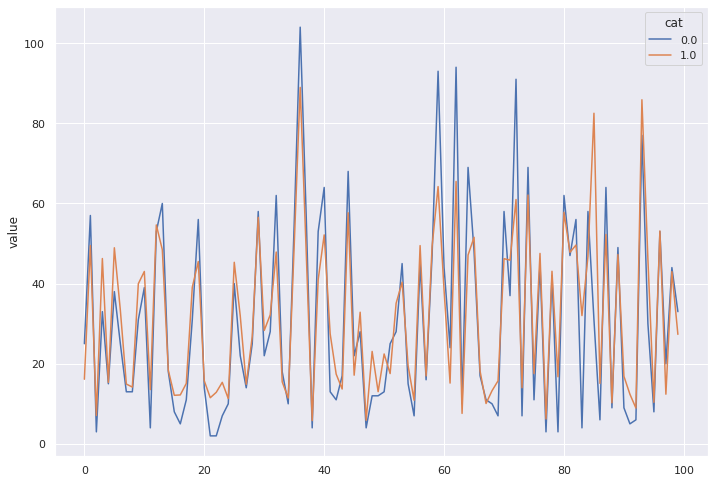

In [38]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=results2, x=results2.index, y="value", hue="cat")

#Probamos ahora con XGBoost

In [39]:
#XGBoost hyper-parameter tuning
param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }
#Create model object
xgb_model = XGBRegressor()
# Instantiate the grid search model
gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 2,
                           n_jobs = -1,
                           verbose = 1)

gsearch.fit(X_train,y_train)
gsearch.best_params_

Fitting 2 folds for each of 288 candidates, totalling 576 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 576 out of 576 | elapsed:  8.8min finished


{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

In [40]:
best_xg_model = gsearch.best_estimator_
metrics_xg_boosted = evaluate(best_xg_model, X_test, y_test)

Model Performance
MAE: 7.22 trucks.
MSE: 102.76.
RMSE: 10.14 trucks.
R2: 85.33.
% Var Explained: 85.39.


In [41]:
y_pred_xgb_vali = best_xg_model.predict(X_vali)
metrics_xg_boosted_vali = evaluate(best_xg_model, X_vali, y_vali)

Model Performance
MAE: 6.92 trucks.
MSE: 92.78.
RMSE: 9.63 trucks.
R2: 86.40.
% Var Explained: 86.51.


In [42]:
real_cat = np.zeros(len(y_vali))
real_cat1 = np.ones(len(y_vali))

results = pd.DataFrame({'value': y_vali, "cat": real_cat}, columns=['value', 'cat']).iloc[0:100]
results1 = pd.DataFrame({'value': y_pred_xgb_vali, "cat": real_cat1}, columns=['value', 'cat']).iloc[0:100]
results2 = pd.concat([results, results1], axis=0)
results2["cat"] = results2["cat"].astype(str)

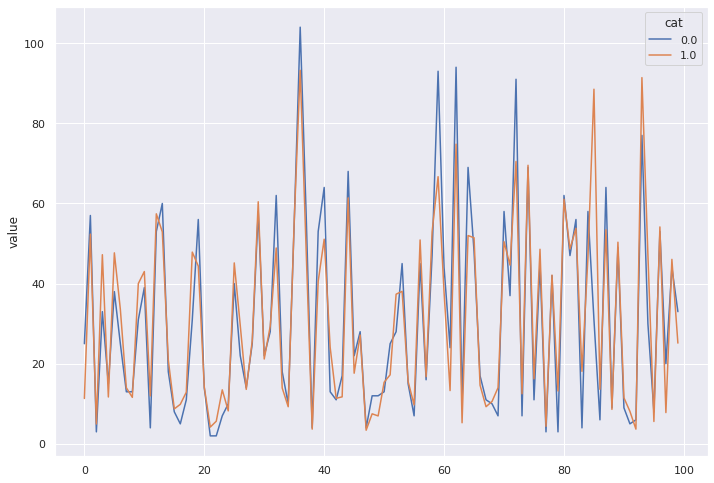

In [43]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.lineplot(data=results2, x=results2.index, y="value", hue="cat")

# Guardamos el modelo

In [44]:
import joblib  
#save model
joblib.dump(best_xg_model, 'modelocalle80_Out.pkl')

['modelocalle80_Out.pkl']